## 1. Project Description
### 1.1 Project Description
The aim of this project is to create a GAN model to learn from Monet painting images and turn new input photos into Monet style images.

### 1.2 Project Background
As AI progressed tremendously over the past few decades and beating humans at many logic-based tasks such as Chess and Go, people have always wondered, can these machines outperform humans in terms of creativity? While genuine computer creativity still seems far-fetched, advancements in computer vision and deep learning have introduced the capability for computers to mimick the fine works of human artists. One technique for achieving this is called generative adversarial networks or GANs in short.

A GAN consists of two types of neural networks: a generator model and a discriminator model. The generator model is a neural network that creates "fake" images, and in our case, it should generate Monet style images. And the discriminator model then looks at the image generated, and train the generator to let it know whether the image is good enough or not. The two models are in effect working against each other (hence the name adversarial networks), the generator tries to trick the discriminator while the discriminator tries to accurately classify real vs. generated images.

### 1.3 Project Evaluation
The results are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID, the better the generated images are.

For a detailed explanation of MiFID and FID, please see [here](https://www.kaggle.com/competitions/gan-getting-started/overview/evaluation).

-----------------

## 2. The Data
### 2.1 Data Description
The dataset for this project contains 300 Monet paintings sized 256x256 (RGB) and 7028 photos sized 256x256 (RGB). The paintings and photos are stored in both JPEG and TFRecord format.

### 2.2 Data Source
This dataset only contains Monet paints, and can be found on [Kaggle](https://www.kaggle.com/competitions/gan-getting-started/data).

For a larger dataset that also contains works from Cezanne, Ukiyo-e, and Van Gogn, please see [here](https://github.com/junyanz/CycleGAN).

-------------

## 3. Loading the Libraries and Data
### 3.1 Loading the Libraries

In [4]:
# 1. Loading the common modules
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from kaggle_datasets import KaggleDatasets # for loading the Kaggle data

In [5]:
# 2. Loading the deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [7]:
# 3. Setting up the TPU, which is needed to significantly speed up our GAN
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-05-23 09:00:57.217012: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-23 09:00:57.217173: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}
2022-05-23 09:00:57.222991: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-23 09:00:57.223142: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}


Number of replicas: 8
2.4.1


### 3.2 Loading the Data
We will work with the TFRecords file format. We will load in the filenames of our photos and Monet paintings one by one.

In [8]:
file_path = KaggleDatasets().get_gcs_path() # Note: Kaggle is owned by Google and uses Google Cloud Storage

In [12]:
MONET_filenames = tf.io.gfile.glob(str(file_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_filenames))

PHOTO_filenames = tf.io.gfile.glob(str(file_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-05-23 09:02:34.199625: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-23 09:02:34.289567: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


All of the images are 256x256 and are in RGB, so we will have 3 channels. We will also need to scale the images as usual, to a [-1,1] scale. We will then simply return the image itself, since we don't require labels for the generative model.

In [9]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [13]:
monet_images = load_dataset(MONET_filenames, labeled=True).batch(1)
photo_images = load_dataset(PHOTO_filenames, labeled=True).batch(1)

In [13]:
print(f'There are {len(list(monet_images))} Monet paintings in our data set')
print(f'There are {len(list(photo_images))} photo images in our data set')

There are 300 Monet paintings in our data set
There are 7038 photo images in our data set


In [12]:
# Defining a function for displaying our images
# code adapted from Ruchi Bhatia's Getting started with GANs notebooks
def display_img(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image= image_path[0]*0.5+0.5
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

**Monet painting images**

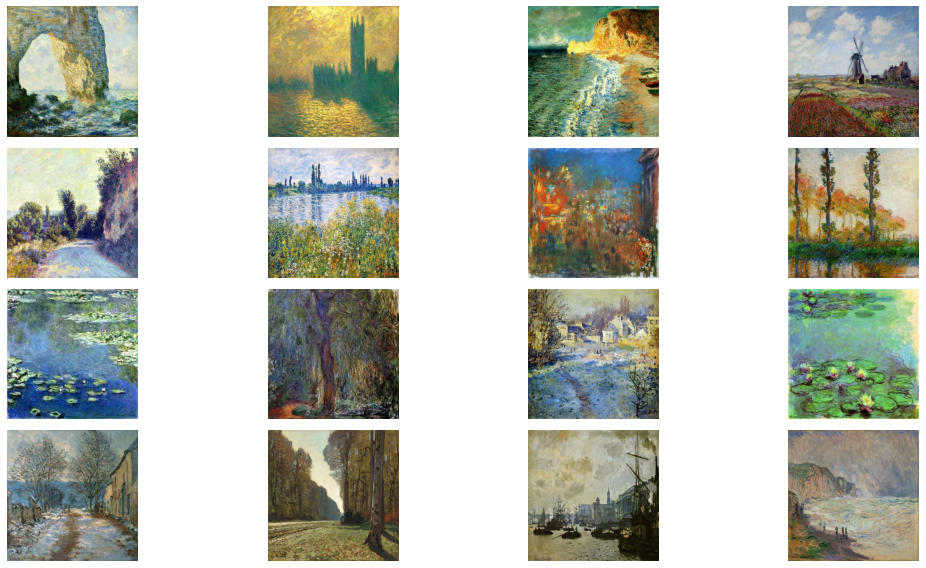

In [16]:
display_img(monet_images, 4, 4)

**Photo Images**

2022-05-23 04:25:20.642745: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 66161, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1653279920.642669078","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 66161, Output num: 0","grpc_status":3}


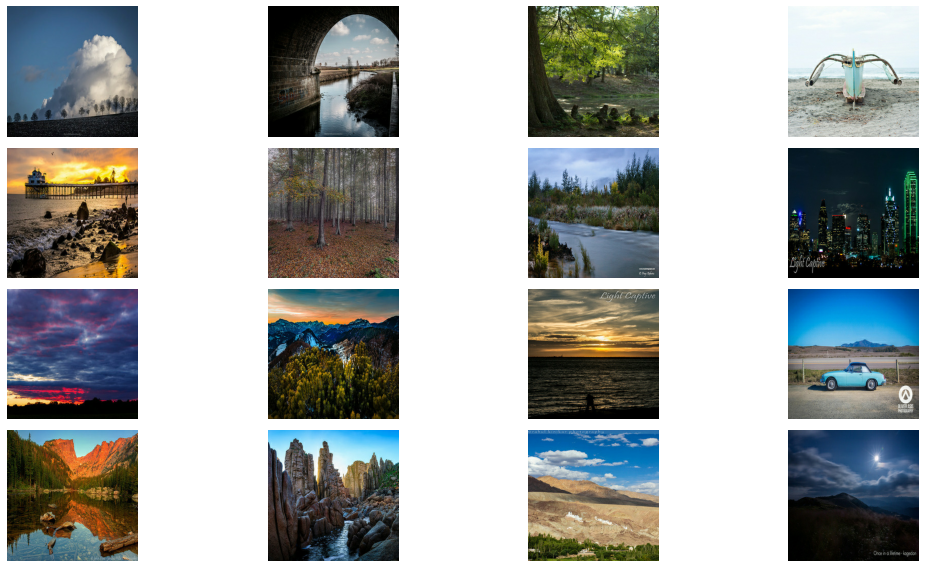

In [17]:
display_img(photo_images, 4, 4)

-----------

## 4. Exploratory Data Analysis (EDA)

One way to visually explore image data is to investigate the distribution of pixel intensities using histogram. Since we have RGB images, we can plot each of the red, green and blue color channels separately. We can also compare if Monet's paintings pixel intensity distribution shares similaries or differences with the photos' pixel intensities.

The plotting code is based on Ruchi Bhatia's Getting started with GANs notebook, it was originally suited to images from the JPEG format. It has been adapted here to suit the particular characteristics of our images which are the tensorflow.python.framework.ops.EagerTensor object in tf.float32 format.

In [14]:
def styling():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        plt.xticks([])
        plt.yticks([])

In [15]:
def plot_hist(image_path):
    plt.figure(figsize=(16, 3))
    
    img = image_path[0]*0.5+0.5 #  shape=(256, 256, 3)
    
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    styling()
    
    custom_colors = ["crimson", "seagreen", "dodgerblue","antiquewhite"]
    labels = ['Red Color Channel', 'Green Color Channel', 'Blue Color Channel','Total (RGB)']
    
    for i in range(1,4):
        colorpixels = np.array(img[:,:,i-1]).flatten()
        plt.subplot(1, 5, i+1)
        plt.hist(colorpixels,bins=64, color=custom_colors[i-1], alpha = 0.6)
        plt.xlabel(labels[i-1],fontsize=10)
        styling()
        
    plt.subplot(1, 5, 5)
    plt.hist(np.array(img).flatten(),bins=128, color=custom_colors[3], alpha = 0.6)
    plt.xlabel(labels[3],fontsize=10)
    styling()
    plt.show()

def display_color_hist(images_paths):
        for ind,image_path in enumerate(images_paths):
            if (ind<6):
                plot_hist(image_path)

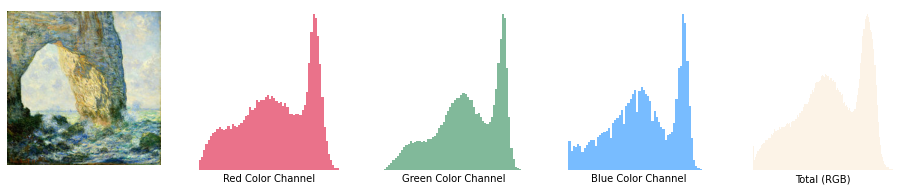

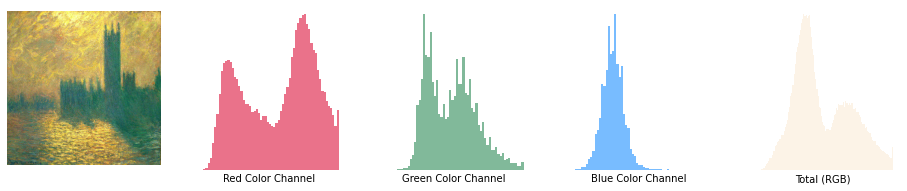

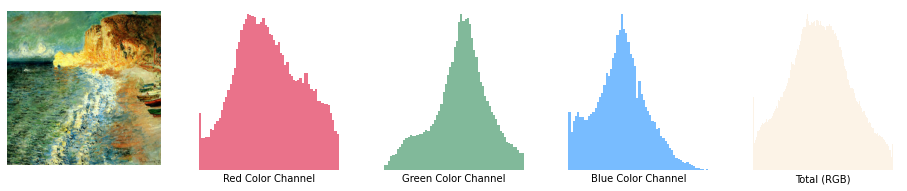

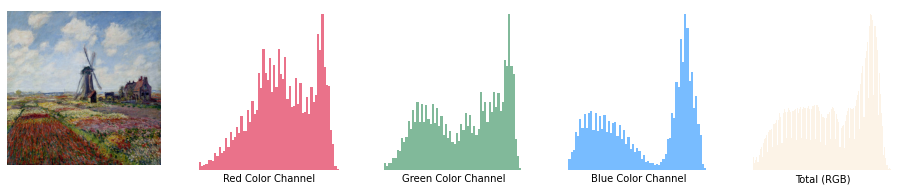

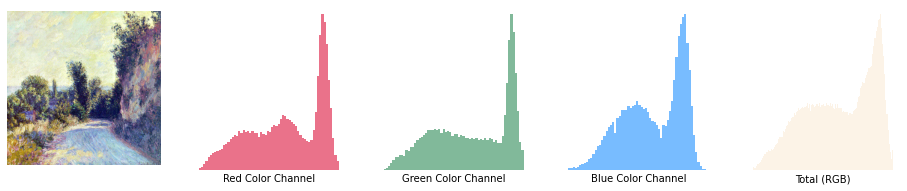

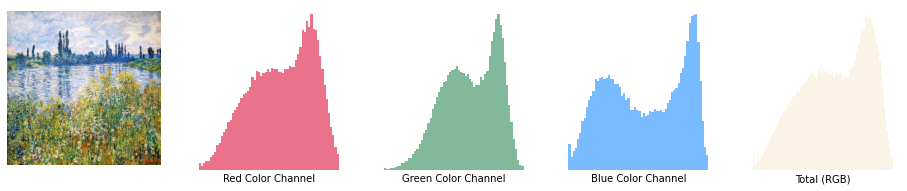

In [20]:
display_color_hist(monet_images)

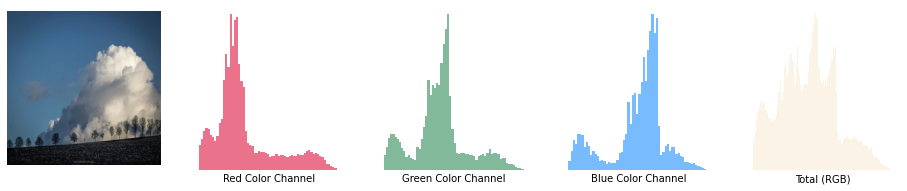

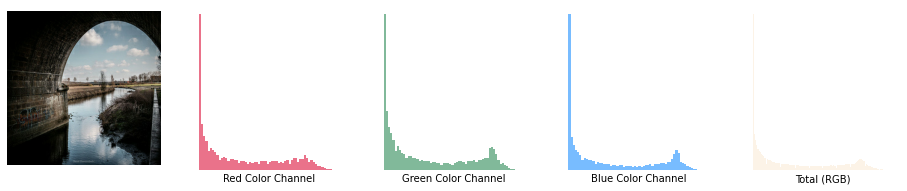

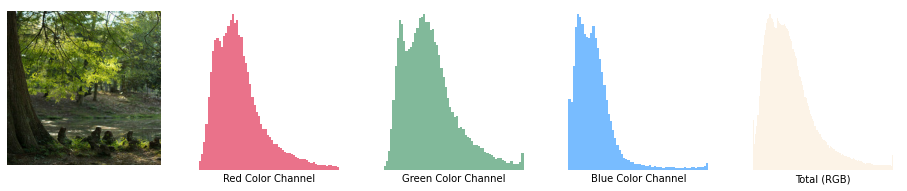

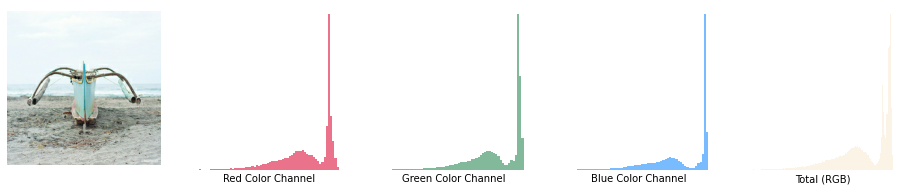

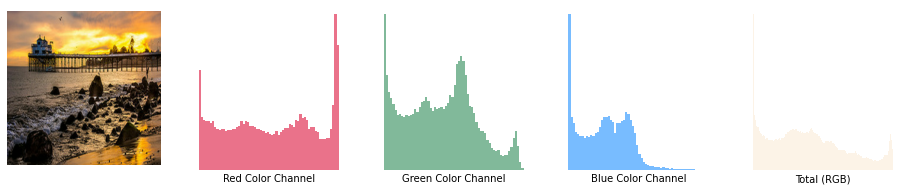

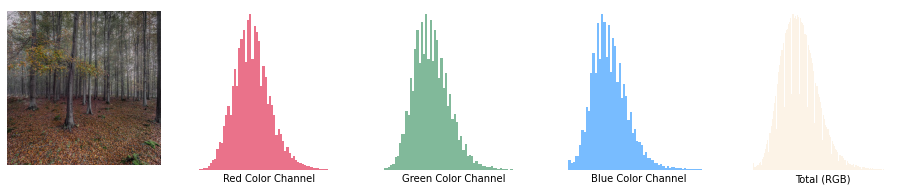

In [21]:
display_color_hist(photo_images)

Based on the images shown, we can make the following observations:
1. Monet's paintings generally have less extreme color pixel distributions and are more "smooth" and "harmonious" than the photo images.
2. In most of Monet's paintings, there often seems to be one dominant tone but also a complementary tone, this is evident from the bimodal shape of the color pixels. Whereas in the photos, the distribution of pixels are more random, it really varies from photo to photo.
3. There seems to be more red pixels relative to green and blue in Monet's paintings compared with the photo images.

Hopefully our GAN model will be able to pick up these characteristics and transfer Monet's style to the photo images.


-----------

## 5. Modelling

### 5.1 How GANs work
Before we dive into the construction of the GAN model, let's first gain a bit more intuition of how GANs work. 

A GAN model is generally composed of two components:
1. A Generator model who generates or creates fake data (such as images, sounds...etc)
2. A Discriminator model who compares generated data with some real data and classifies the generated data as fake or real.

A good Generator model will be able to learn and improve its generated data, and in the end be able to fool the Discriminator into accepting the fake data as real.

![image.png](https://miro.medium.com/max/1400/1*TKr1dtcNgJCA8uYY1OhmSg.png)
Image: [Sarvsv Kulpati](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2Fsigmoid%2Fa-brief-introduction-to-gans-and-how-to-code-them-2620ee465c30&psig=AOvVaw1tlX91xbGTF6WzR4bCL_ou&ust=1653357271902000&source=images&cd=vfe&ved=0CA0QjhxqFwoTCKDjuvvB9PcCFQAAAAAdAAAAABAD)

There are many ways to implement GANs, and in the space of our style-transfer problem, one of the most popular ways is called Cycle-Consistent GANS or **CycleGANs**. 

According to [tensorflow documentation](https://www.tensorflow.org/tutorials/generative/cyclegan#:~:text=CycleGAN%20uses%20a%20cycle%20consistency,the%20source%20and%20target%20domain.) "CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain". 

CycleGANs are especially suited for tasks including:
1. Photo-enhancement
2. Image colorization
3. Style transfer

Below are some examples:

![image.png](https://www.tensorflow.org/tutorials/generative/images/horse2zebra_1.png)!
![image.png](https://www.tensorflow.org/tutorials/generative/images/horse2zebra_2.png)!

In the CycleGAN approach not only one, but two Generative Adversarial Networks are trained. The first GAN learns the forward transformation to the target and the second GAN learns the inverse transformation back to the original. The intuition is that if we translate an image from one domain (e.g. original photo) to the other (e.g. Monet style image) and back again, then we should arrive at where we started. And loss is calculated between the original image and the final generated image, which should look exactly the same as the original.

**Forward Cycle: Photo -> GeneratorA -> Monet Style --> GeneratorB -> Photo**

**Backward Cycle: Monet -> GeneratorB -> Photo Style -> GeneratorA -> Monet**


There are a couple of more concepts that we have to define before building our models. 

The first is "downsample"， which is used to reduce the 2D image's dimensions (width x height) by the specified stride. The stride is the step size that the filter takes. For example, a stride of 1 means that the filter is applied to every pixel of the image. A stride of 2 means that the filter is applied to every second pixel (skipping the one in between).

The second is "upsampling", which is the opposite of downsample, it increases the dimensions of the 2D image. Each upsampling layer represents a transpose convolution with a certain stride.

The generator uses Conv2DTranspose and the discriminator uses Conv2D layer. The final output shape is defined by the size of the training images, which in our case is 256x256.



### 5.2 Building the Generator
The generator behaves in the following way:
1. It first downsamples the input images.
2. It then upsamples while establishing long skip connections. These skip connections are used to avoid the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.

In [16]:
OUTPUT_CHANNELS = 3
# Let's first define our downsample function

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

# And now the upsample function
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [17]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling 
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip]) #We are concatenating the output of the downsample layer to the upsample layer in a symmetrical fashion.

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### 5.3 Building the Discriminator

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [19]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-style images --forward
    photo_generator = Generator() # transforms Monet images to photos --backward

    monet_discriminator = Discriminator() # differentiates real Monet and generated Monet-style images
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### 5.4 Combining to build the CycleGAN Model
The codes here are based on Amy Jang's notebook [here](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial).
It works exactly in the same way we have described in section 5.1, where during training, our model transforms a photo to Monet style image, and the back to the photo. The difference between the original and the transformed version of the photo is the cycle-consistency loss, we want to minimize this loss.

In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [21]:
# The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    
# The perfect generator will make the discriminator output only 1s (real), so we compare the generated image to a matrix of 1s to find the loss.
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
# We want our original photo and the transformed photo to be similar to each other. Thus, we can calculate the cycle consistency loss to find the average of their difference.
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
# The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### 5.5 Training the Model

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5) #3e-4 ~ 5e-4 tends to be good learning rates for Adam, we will try 4e-4 here
    photo_generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [34]:
# cycle_gan_model.fit(
#     tf.data.Dataset.zip((monet_images, photo_images)),
#     epochs=40
# )

Epoch 1/40
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.5602 - photo_gen_loss: 3.5584 - monet_disc_loss: 0.6429 - photo_disc_loss: 0.6676
Epoch 2/40
  1/300 [..............................] - ETA: 49s - monet_gen_loss: 3.0679 - photo_gen_loss: 2.5457 - monet_disc_loss: 0.4541 - photo_disc_loss: 0.6284

2022-05-23 04:32:08.834864: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 89306, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1653280328.834784576","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 89306, Output num: 1","grpc_status":3}


300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.3819 - photo_gen_loss: 3.3445 - monet_disc_loss: 0.6356 - photo_disc_loss: 0.6585
Epoch 3/40
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.1568 - photo_gen_loss: 3.1185 - monet_disc_loss: 0.6255 - photo_disc_loss: 0.6524
Epoch 4/40
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.0676 - photo_gen_loss: 3.0290 - monet_disc_loss: 0.6201 - photo_disc_loss: 0.6503
Epoch 5/40
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.0042 - photo_gen_loss: 2.9561 - monet_disc_loss: 0.6152 - photo_disc_loss: 0.6507
Epoch 6/40
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 2.9418 - photo_gen_loss: 2.8828 - monet_disc_loss: 0.6098 - photo_disc_loss: 0.6507
Epoch 7/40
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 2.8910 - photo_gen_loss: 2.8236 - monet_disc_loss: 0.6069 - photo_dis


The first model achieved a Public Score of 55.45 on Kaggle.

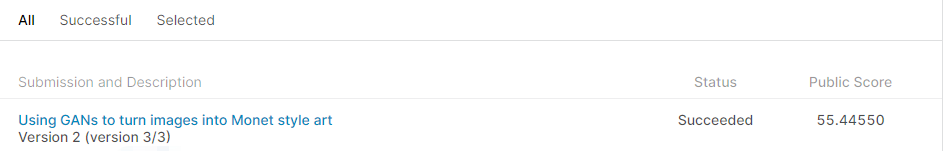

**Improving CycleGAN results by increasing epochs**

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_images, photo_images)),
    epochs=100
)

Epoch 1/100
300/300 [==============================] - 141s 124ms/step - monet_gen_loss: 4.4872 - photo_gen_loss: 4.6014 - monet_disc_loss: 0.6719 - photo_disc_loss: 0.6674
Epoch 2/100
  1/300 [..............................] - ETA: 1:00 - monet_gen_loss: 2.9475 - photo_gen_loss: 2.9123 - monet_disc_loss: 0.6244 - photo_disc_loss: 0.6535

2022-05-23 09:05:53.236395: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 12541, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1653296753.233112441","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 12541, Output num: 3","grpc_status":3}


300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.4915 - photo_gen_loss: 3.5687 - monet_disc_loss: 0.6637 - photo_disc_loss: 0.6526
Epoch 3/100
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.3168 - photo_gen_loss: 3.3461 - monet_disc_loss: 0.6403 - photo_disc_loss: 0.6485
Epoch 4/100
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.1311 - photo_gen_loss: 3.1181 - monet_disc_loss: 0.6293 - photo_disc_loss: 0.6453
Epoch 5/100
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.0706 - photo_gen_loss: 3.0441 - monet_disc_loss: 0.6250 - photo_disc_loss: 0.6454
Epoch 6/100
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.0039 - photo_gen_loss: 2.9815 - monet_disc_loss: 0.6241 - photo_disc_loss: 0.6428
Epoch 7/100
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 2.9376 - photo_gen_loss: 2.9136 - monet_disc_loss: 0.6217 - phot

The second model achieved a Public Score of 49.33 on Kaggle, which is an improvement of 6 points from previously. I believe if we train longer we should be able to achieve better scores.

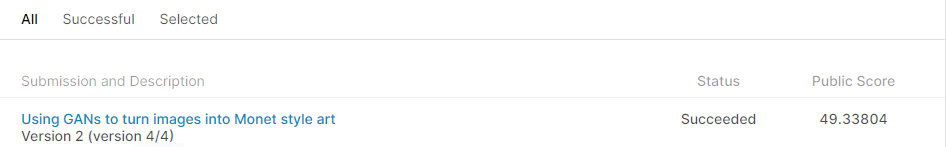

---------------

## 6. Discussion of Results

2022-05-23 05:01:05.339619: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 243125, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1653282065.339576991","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 243125, Output num: 0","grpc_status":3}


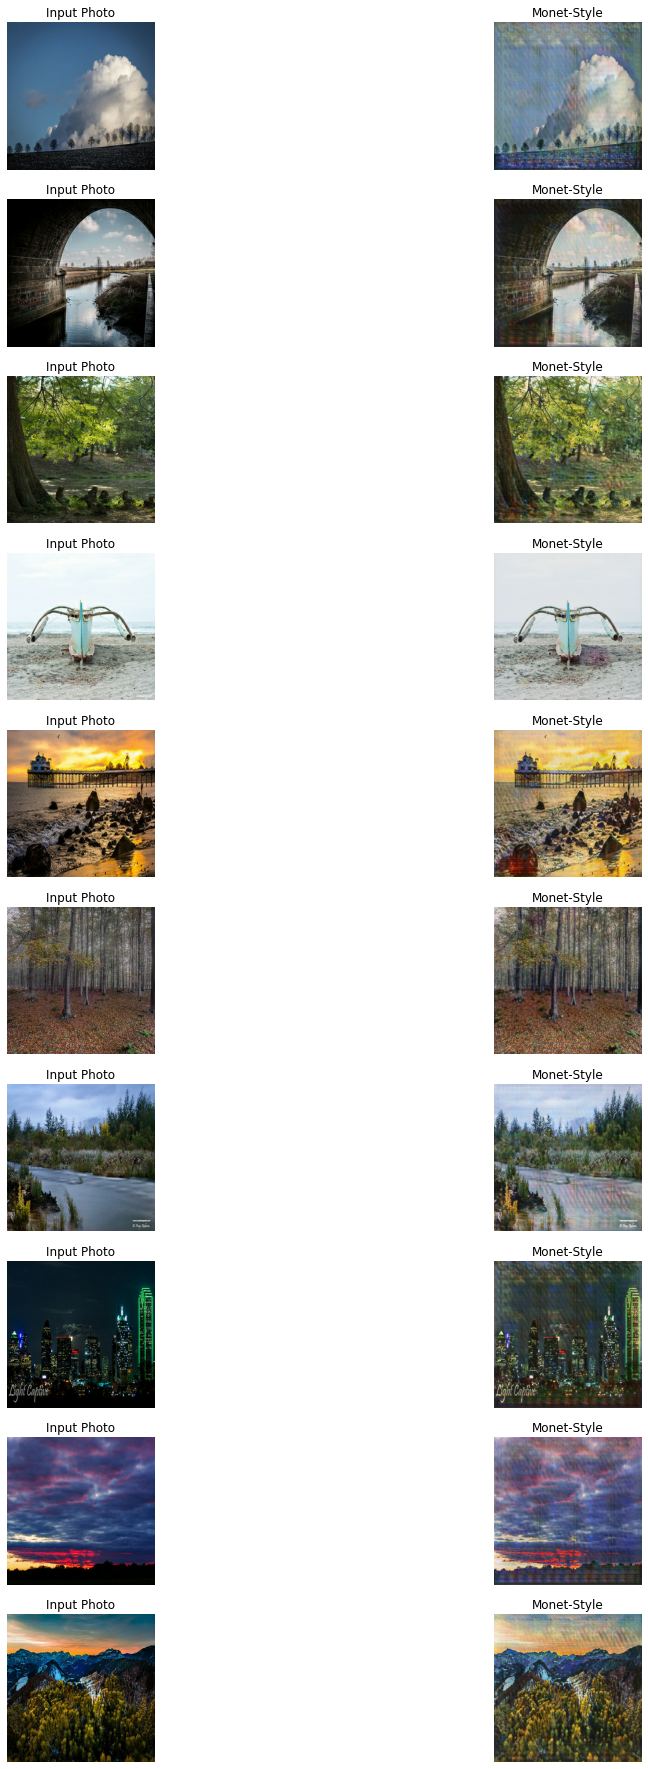

In [42]:
_, ax = plt.subplots(10, 2, figsize=(16, 32))
for i, img in enumerate(photo_images.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Just by visually inspecting the original photos and the transformed Monet-style photos, we can see that some of the outputs are really nice and resemble impressionist oil paintings (like the 2nd, 3rd and last images), while some are not so great (like 4th last image). 

Through our modelling and training we can also note the following potential improvements:
1. We should be able to achieve better results through longer epochs, as we have seen our MiFID score significantly improved by increasing from 40 epochs to 100 epochs.
2. We only have 300 Monet paints to start with, which is a relatively small set of data. Perhaps we can use data augmentation techniques to help us increase our useful learning examples, and which in turn should improve our model results.

--------

## 7. Conclusion

In this project, we created a GAN model, more specifically a CycleGAN model to achieve style transfer for transforming input photos into Monet style images. In the CycleGAN model, we built a forward cycle and a backward cycle with two generators and two discriminators. Our final model trained using 100 epochs and achieved an MiFID (Memorization-informed Fréchet Inception Distance) 44.34 on Kaggle.

---------------

#### Submission

In [44]:
import PIL
! mkdir ../images

In [ ]:
#from tqdm.notebook import tqdm_notebook

In [ ]:
i = 1
for img in photo_images:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [49]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [50]:
# import os
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink
# FileLink(r'images.zip')

/kaggle/working/images.zip